<a href="https://colab.research.google.com/github/gummy-brain/EDA-of-Mental-Health-in-Tech-Industry/blob/main/%E2%80%9E215_ipynb%E2%80%9C_kopija.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project was prepared while studying at Turing College. The objectives were to 
- work with SQLite datasets;
- perform EDA;
- visualize data with Matplotlib & Seaborn;
- read data, perform queries and filter data using SQL and Pandas.

# **Exploring Mental Health in Tech Industry**

## **Introduction**

The cornerstone of this EDA is the survey data on [mental health in the tech industry](https://www.kaggle.com/anth7310/mental-health-in-the-tech-industry) gathered in the years of 2014 to 2017 by a non-profit organization named Open Source Mental Illnes (OSMI).

The main goal of this EDA is to investigate openness about mental health among the workers of tech industries and, thus, to provide employers with insights on how to help their employees be more vocal about mental health problems.

The EDA will be organized into three parts. Firstly, data cleaning and an overview of survey questions will take place. 
The second part will allow to take a glance at the general tendencies concerning mental health in tech industries and will help on deciding whether it is a pressing issue. Lastly, the focal point of the EDA will be shifted to employee openness about their mental health. Both the influence of demographic factors and of the working environment will be assessed to gain insights about what determines workers' willingnes to talk about their mental health issues.

The EDA will be finalized with conclusions and practical suggestions for the employers in the tech industry.

## **1. Data Preparation**

In [ ]:
!python -m pip install -U pip
!python -m pip install -U matplotlib

In [ ]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [ ]:
con = sql.connect("/content/mental_health.sqlite")

answer_data = pd.read_sql_query("SELECT * FROM Answer", con)
answer_data.head()

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


In [ ]:
question_data = pd.read_sql_query("SELECT * FROM Question", con)
question_data.head()

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5


In [ ]:
 survey_data = pd.read_sql_query("SELECT * FROM Survey", con)
 survey_data.head()

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


The third table of the survey database will not be used in this EDA as it does not hold any significant information.

In [ ]:
print(f'There are {answer_data.shape[0]} records in the Answer table \
and {question_data.shape[0]} records in the Question table.')

There are 236898 records in the Answer table and 105 records in the Question table.


### Checking for missing values and duplicate records

In [ ]:
print(f'Missing Values in the Answer Table:\n\n{answer_data.isnull().sum()}\n\n\
Missing Values in the Question Table:\n\n{question_data.isnull().sum()}')

Missing Values in the Answer Table:

AnswerText    0
SurveyID      0
UserID        0
QuestionID    0
dtype: int64

Missing Values in the Question Table:

questiontext    0
questionid      0
dtype: int64


The fact that no missing values were found in the `Answer` table does not mean that survey respondents thoroughly filled every of their answers. Probably, missing information was coded in a different way. This will be kept in mind while assesing answers of particular survey questions.

In [ ]:
print(f'Duplicated Rows in the Answer Table: {answer_data.duplicated().sum()}\
\n\nDuplicated Rows in the Question Table: {question_data.duplicated().sum()}')

Duplicated Rows in the Answer Table: 0

Duplicated Rows in the Question Table: 0


### Counting survey respondents

How many respondents participated in the mental health survey in total?

In [ ]:
query = """
        SELECT COUNT(DISTINCT UserID) AS RespondentCount
        FROM Answer
        """
respondents_total = pd.read_sql(query, con)
print(f'A total of {respondents_total.iloc[0].values} respondents \
participated in the Mental Health Survey.')

A total of [4218] respondents participated in the Mental Health Survey.


How many respondents participated in the survey each year?

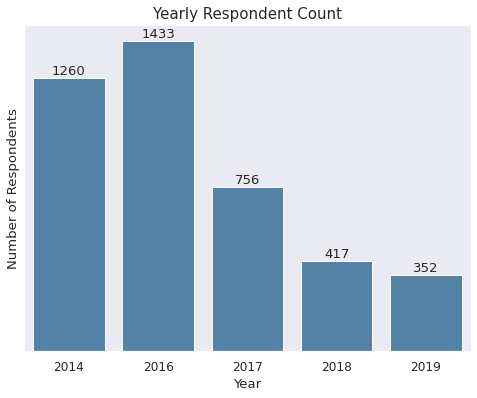

In [ ]:
query = """
        SELECT SurveyID AS Year, COUNT(DISTINCT UserID) AS RespondentCount
        FROM Answer
        GROUP BY SurveyID
        ORDER BY SurveyID
        """
yearly_respondents = pd.read_sql(query, con)

sns.set_style("darkgrid")
sns.set(font_scale = 1.1)
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=yearly_respondents, x="Year", y="RespondentCount", 
                 color="steelblue")
plt.title('Yearly Respondent Count', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Number of Respondents')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.show()

Were there any returning respondents?

In [ ]:
query = """
        WITH RespondentsByYear AS (SELECT SurveyID, UserID
                                   FROM Answer
                                   GROUP BY SurveyID, UserID)
        SELECT UserID AS ReturningRespondents, COUNT(UserID) AS Returns
        FROM RespondentsByYear
        GROUP BY UserID
        HAVING COUNT(UserID) > 1
        """
returning_respondents = pd.read_sql(query, con)
print(f"There were {returning_respondents['ReturningRespondents'].count()} \
returning respondents.")

There were 0 returning respondents.


As there are no returning survey respondents, records from different survey years can be safely pooled together.

Since the focus of this EDA is mental health in tech industry in particular, we need to find out how many survey respondents are actually related to it. I. e., which of the respondents are employed in a tech industry (question 9) and which of them have a role related to tech/IT (question 13)?

In [ ]:
query = """WITH Status as (SELECT "Employed in Tech" AS Status, 
                                   (CASE
                                      WHEN AnswerText = "1" THEN "Yes"
                                      WHEN AnswerText = "0" THEN "No"
                                      ELSE "No Answer"
                                      END) AS Result, 
                                    COUNT(DISTINCT UserID) AS RespondentCount
                            FROM Answer
                            WHERE QuestionID = 9 and SurveyID != 2014
                            GROUP BY Result
                            UNION ALL
                            SELECT "Role in Tech" AS Status, 
                                   (CASE
                                      WHEN AnswerText = "1" THEN "Yes"
                                      WHEN AnswerText = "0" THEN "No"
                                      ELSE "No Answer"
                                      END) AS Result,  
                                    COUNT(DISTINCT UserID) AS RespondentCount
                            FROM Answer
                            WHERE QuestionID = 13 AND SurveyID != 2014
                            GROUP BY Result)
           SELECT Status,
                  MAX(CASE WHEN Result = "Yes" THEN RespondentCount END) AS Yes,
                  MAX(CASE WHEN Result = "No" THEN RespondentCount END) AS No,
                  MAX(CASE WHEN Result = "No Answer" THEN RespondentCount END) 
                  AS "No Answer"
           FROM Status
           GROUP BY Status
        """
tech_respondents = pd.read_sql(query, con, index_col="Status")
tech_respondents

,Yes,No,No Answer
Status,,,
Employed in Tech,1857,597,504
Role in Tech,1471,100,1387


The categories of those employed in tech and those with a role in tech might overlap. So, what is the total number of tech respondents?

In [ ]:
query = """SELECT COUNT(DISTINCT UserID) as TechRespondents
           FROM Answer
           WHERE (SurveyID != 2014 
           AND (QuestionID = 9 AND AnswerText = 1) 
           OR (QuestionID = 13 AND AnswerText = 1))
        """
tech_respondents = pd.read_sql(query, con)
tech_respondents

print(f"A total of {tech_respondents.iloc[0].values} respondents working in \
tech industry participated in the Mental Health Survey. \n\
Only their UserIDs will be used for further analysis.")

A total of [2419] respondents working in tech industry participated in the Mental Health Survey. 
Only their UserIDs will be used for further analysis.


### Exploring the survey questions

What is the total number of survey questions?

In [ ]:
query = """
        SELECT DISTINCT QuestionID, QuestionText
        FROM Question
        """
questions = pd.read_sql(query, con)

print(f"There are {questions.shape[0]} survey questions in the data set.")

There are 105 survey questions in the data set.


What was the survey question count each year?

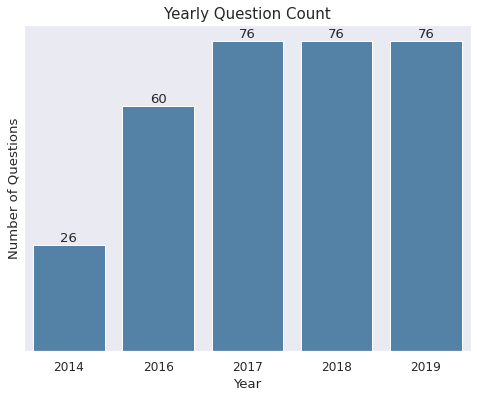

In [ ]:
query = """
        SELECT SurveyID AS Year, COUNT(DISTINCT QuestionID) AS QuestionCount
        FROM Answer 
        GROUP BY Year
        ORDER BY Year
        """
yearly_question_count = pd.read_sql(query, con)

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=yearly_question_count, x="Year", y="QuestionCount", 
                 color="steelblue")
plt.title('Yearly Question Count', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Number of Questions')
ax.bar_label(ax.containers[0])
plt.yticks([])
plt.show()

While the respondent count drasticly decreased since the first survey, the number of survey questions highly increased. 

Are there any questions that were repeated across different years of the survey?

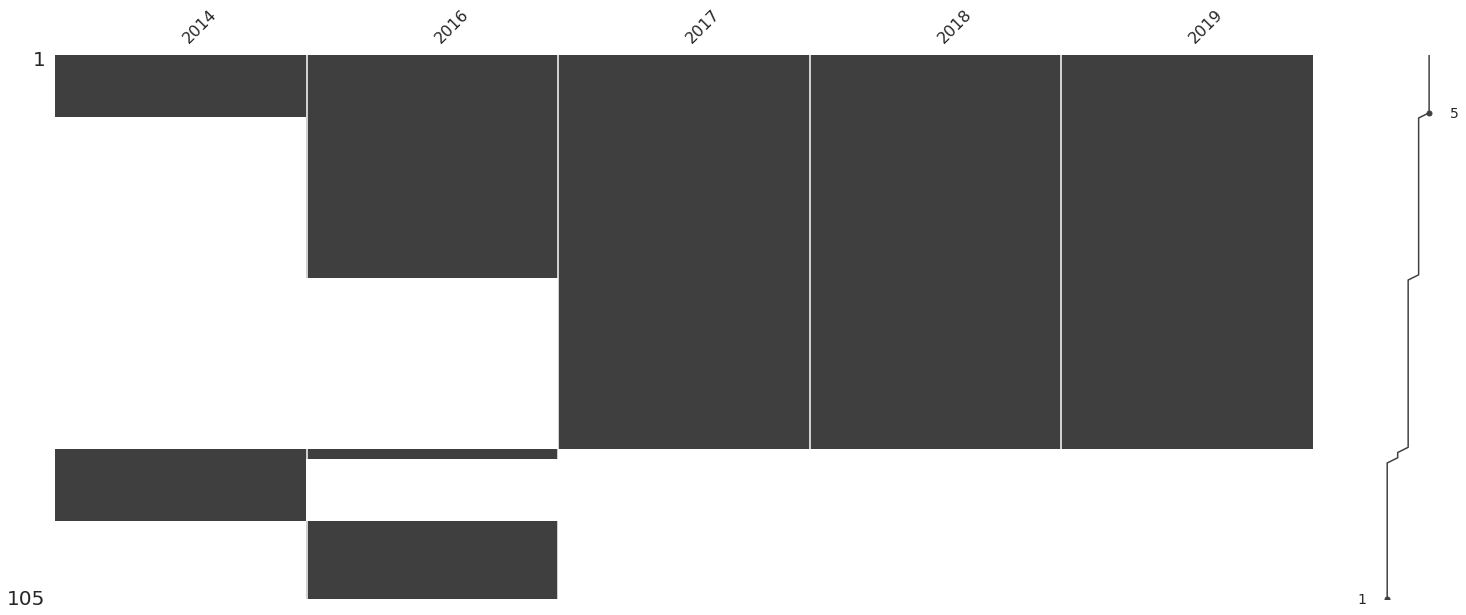

In [ ]:
query = """ 
        SELECT Answer.SurveyID, Answer.QuestionID, 
        Question.questiontext AS QuestionText
        FROM Question
        INNER JOIN Answer ON Question.QuestionID=Answer.QuestionID
        GROUP BY SurveyID, Question.QuestionID
        ORDER BY SurveyID, Question.QuestionID
        """
questions_by_year = pd.read_sql(query, con)
questions_by_year = pd.pivot(questions_by_year, columns="SurveyID", 
                                      index="QuestionID", values="QuestionText")
questions_by_year = questions_by_year.rename_axis("", axis="columns")

msno.matrix(questions_by_year)
plt.show()


We can see that the respondents were given identical questionaires in the years 2017, 2018, and 2019. And some of the questions were repeated across all of the surveys. Let us see which of the questionaires shoud be investigated to make up a comprehensive analysis of mental health in tech industry. 

First of all, we need to discern which of the questions fully overlap:

In [ ]:
same_questions = questions_by_year.dropna()
same_questions.iloc[:, :1].style.set_properties(**{'text-align': 'left'})

,2014
QuestionID,
1,What is your age?
2,What is your gender?
3,What country do you live in?
4,"If you live in the United States, which state or territory do you live in?"
5,Are you self-employed?
6,Do you have a family history of mental illness?
7,Have you ever sought treatment for a mental health disorder from a mental health professional?
8,How many employees does your company or organization have?
9,Is your employer primarily a tech company/organization?


These questions seem to say too little about the mental health status and working environments of the tech employees. Would leaving 2014 questions behind and holding on to repeated questions of surveys of 2016 to 2019 would do better justice?

In [ ]:
questions_2016_2019 = questions_by_year.iloc[:, 1:].dropna()
questions_2016_2019 = questions_2016_2019.iloc[:, :1]
questions_2016_2019.style.set_properties( **{'text-align': 'left'})

,2016
QuestionID,
1,What is your age?
2,What is your gender?
3,What country do you live in?
4,"If you live in the United States, which state or territory do you live in?"
5,Are you self-employed?
6,Do you have a family history of mental illness?
7,Have you ever sought treatment for a mental health disorder from a mental health professional?
8,How many employees does your company or organization have?
9,Is your employer primarily a tech company/organization?


Repeated questions of surveys of 2016 to 2019 seem to provide quite a far-reaching overview of mental health sitaution in tech industry including the data on employee willingness to discuss mental health issues within their working environment. Still, the questions that are left out require an additional check.

In [ ]:
questions_2016 = questions_by_year.iloc[: , 1:2].dropna()
questions_2016 = questions_2016[~questions_2016[2016].isin(
    questions_2016_2019[2016])]
questions_2016.style.set_properties(**{'text-align': 'left'})

,2016
QuestionID,
90,Do you think that discussing a physical health issue with your employer would have negative consequences?
91,Do you feel that your employer takes mental health as seriously as physical health?
104,Do you think that discussing a mental health disorder with your employer would have negative consequences?
105,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?
106,"If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?"
107,"If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?"
108,Do you think that discussing a mental health disorder with previous employers would have negative consequences?
109,Do you think that discussing a physical health issue with previous employers would have negative consequences?
110,Would you have been willing to discuss a mental health issue with your previous co-workers?


In [ ]:
questions_2017= questions_by_year.iloc[: , 2:3].dropna()
questions_2017 = questions_2017[~questions_2017[2017].isin(
    questions_2016_2019[2016])]
questions_2017.style.set_properties(**{'text-align': 'left'})

,2017
QuestionID,
57,Would you feel more comfortable talking to your coworkers about your physical health or your mental health?
58,Have you ever discussed your mental health with your employer?
59,"Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions."
60,Have you ever discussed your mental health with coworkers?
61,Describe the conversation with coworkers you had about your mental health including their reactions.
62,Have you ever had a coworker discuss their or another coworker's mental health with you?
63,Describe the conversation your coworker had with you about their mental health (please do not use names).
64,"Overall, how much importance does your employer place on physical health?"
65,"Overall, how much importance does your employer place on mental health?"


The 2016 survey has some additional questions about the perceived threat of discussing mental health issues but provides relatively little information to help find reasons behind this perception. The surveys of the 2017-2019 follow a more descriptive approach. They hold open-ended questions and help understand the quality of employee past experiencess in discussing mental health problems with coworkers, supervisors etc. It is understandable that 2017-2019 surveys attracted less participants as they require more effort to fill in the questionaires. 

As this EDA follows a quantitative approach, the preference is to have as much observations as possible. That is why the overlapping questions of 2016-2019 surveys were chosen to be the center of this study.

A brief look at the survey answers of one random respondent:

In [ ]:
query = """
        WITH RandomnRespondent AS (SELECT UserID 
                                   FROM Answer
                                   WHERE SurveyID != 2014 
                                   ORDER BY RANDOM() 
                                   LIMIT 1)
        SELECT QuestionID, AnswerText
        FROM Answer, RandomnRespondent
        WHERE Answer.UserID = RandomnRespondent.UserID
        """
random_response = pd.read_sql(query, con, index_col="QuestionID")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
random_response

,AnswerText
QuestionID,
1,56
2,Female
3,United States of America
4,North Carolina
5,0
6,Yes
7,1
8,6-25
9,1


## **2. General Mental Health Situation in Tech Industry**

How many of the respondents were ever affected by a mental health issue, i. e., they reported to currently have or to have had a mental disorder in the past?

In [ ]:
query = """WITH DisorderStatus AS (SELECT UserID,
                                         "Had in Past" AS Status, 
                                         (CASE
                                           WHEN AnswerText = "Yes" THEN 3
                                           WHEN AnswerText IN 
                                           ("Don't Know", "Possibly", "Maybe") 
                                           THEN 1
                                           ELSE 0
                                           END) AS Answer
                                   FROM Answer
                                   WHERE QuestionID = 32
                                   UNION ALL
                                   SELECT UserID,
                                         "Currently Have" AS Status, 
                                          (CASE
                                            WHEN AnswerText = "Yes" THEN 3
                                            WHEN AnswerText IN 
                                            ("Don't Know", "Possibly", "Maybe") 
                                            THEN 1
                                            ELSE 0
                                            END) AS Answer
                                    FROM Answer
                                    WHERE QuestionID = 33),
                  AnswerSum AS (SELECT UserID, SUM(Answer) AS Ans
                                FROM DisorderStatus
                                WHERE UserID IN (SELECT DISTINCT UserID
                                                 FROM Answer
                                                 WHERE (SurveyID != 2014 
                                                 AND (QuestionID = 9 
                                                 AND AnswerText = 1) 
                                                 OR (QuestionID = 13 
                                                 AND AnswerText = 1)))
                                                 GROUP BY UserID),
                  AnswerCount AS (SELECT COUNT(UserID) AS Count, Ans
                        FROM AnswerSum
                        GROUP BY Ans)
                  SELECT "Yes" AS MentalDisorder,
                         SUM(CASE WHEN Ans >= 3 THEN Count END)
                         AS RespondentCount
                  FROM AnswerCount
                  UNION ALL
                  SELECT "Maybe" AS MentalDisorder,
                          SUM(CASE WHEN Ans > 0 AND Ans <3 THEN Count END) 
                          AS RespondentCount
                  FROM AnswerCount
                  UNION ALL
                  SELECT "No" AS MentalDisorder,
                          SUM(CASE WHEN Ans = 0 THEN Count END)
                          AS RespondentCount
                  FROM AnswerCount
          """
disorder_status = pd.read_sql(query, con)
disorder_status

,MentalDisorder,RespondentCount
0,Yes,1312
1,Maybe,545
2,No,562


How many of tech respondents were ever diagnosed with mental disorder?

In [ ]:
query = """SELECT COUNT(AnswerText) as RespondentCount, 
                 (CASE WHEN Answertext in ("Yes", "No") THEN AnswerText
                       ELSE "No answer" 
                       END) AS DiagnosedDisorder
           FROM Answer
           WHERE QuestionID = 34 AND UserID IN (SELECT DISTINCT UserID
                                                FROM answer
                                                WHERE (surveyID != 2014 
                                                AND (questionID = 9 
                                                AND answertext = 1) 
                                                OR (questionID = 13 
                                                AND answertext = 1))) 
           GROUP BY DiagnosedDisorder
         """
diagnosis_status = pd.read_sql(query, con)
diagnosis_status

,RespondentCount,DiagnosedDisorder
0,581,No
1,727,No answer
2,1111,Yes


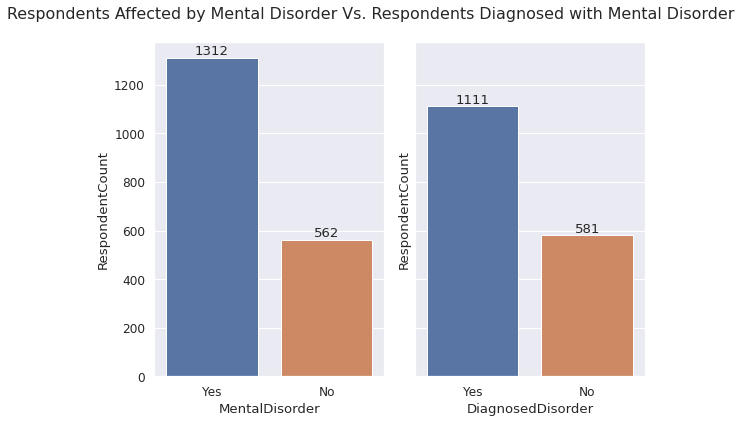

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 6))
fig.suptitle("Respondents Affected by Mental Disorder Vs. Respondents \
Diagnosed with Mental Disorder")
order = ["Yes", "No"]
sns.barplot(data=disorder_status, 
            x="MentalDisorder", 
            y="RespondentCount", 
            ax=ax[0], 
            order=order)
ax[0].bar_label(ax[0].containers[0])
sns.barplot(data=diagnosis_status, 
            x="DiagnosedDisorder", 
            y="RespondentCount", 
            ax=ax[1], 
            order=order)
ax[1].bar_label(ax[1].containers[0])
plt.tight_layout()

According to survey asnwers, more than half of the respondents were affected by a mental health disorder at some point in their life and 85% of them have been diagnosed officialy. Thus, mental health disorders seem to be a truly pressing issue in the tech industry.

How is the work of those respondents who ever had a mental disorder affected? How ofent the disorder inteferes with their work if it is treated effectively and how when it is not?

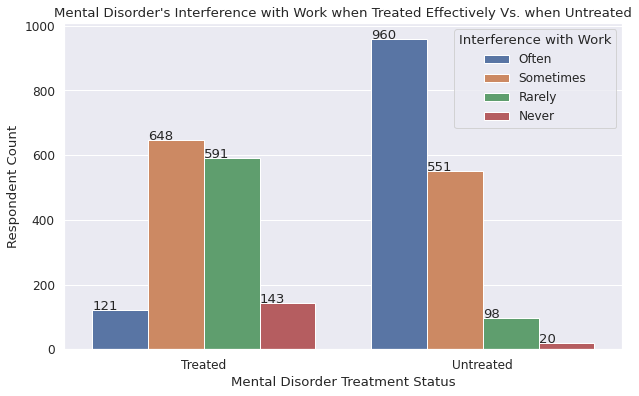

In [ ]:
query = """WITH Tech as (SELECT DISTINCT userID
                         FROM answer
                         WHERE (surveyID != 2014 
                         AND (questionID = 9 AND answertext = 1) 
                         OR (questionID = 13 and answertext = 1))),
        
                TreatmentStatus AS (SELECT "Treated" AS TreatmentStatus, 
                                   Answertext AS Result, 
                                   COUNT(DISTINCT UserID) AS Count
                           FROM Answer
                           WHERE QuestionID = 48 and UserId in Tech
                           GROUP BY Result
                           UNION ALL
                           SELECT "Untreated" AS TreatmentStatus, 
                                   Answertext AS Result, 
                                   COUNT(DISTINCT UserID) AS Count
                           FROM Answer
                           WHERE QuestionID = 49 and userId in Tech
                           GROUP BY Result)
           
           SELECT TreatmentStatus,
                  MAX(CASE WHEN Result = "Never" THEN Count END) AS Never,
                  MAX(CASE WHEN Result = "Often" THEN Count END) AS Often,
                  MAX(CASE WHEN Result = "Rarely" THEN Count END) AS Rarely,
                  MAX(CASE WHEN Result = "Sometimes" THEN Count END) 
                  AS Sometimes
           FROM TreatmentStatus
           GROUP BY TreatmentStatus
         """
disorder_treatment = pd.read_sql(query, con)
disorder_treatment_melted = \
pd.melt(disorder_treatment, 
        id_vars=["TreatmentStatus"], 
        value_vars=["Often", "Sometimes", "Rarely", "Never"], 
        var_name="Interference", 
        value_name="RespondentCount")

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=disorder_treatment_melted, 
            y="RespondentCount", 
            x="TreatmentStatus", 
            hue="Interference")

def addbarlabel(percent=None):
  """Returns labels for every barplot container with values of y and and with 
     values of y rounded to nearest tenth with a % symbol if the parameter is 
     specified as "%".
    
     Parameters:
     percent (str) : Default=None; "%" to form labels with percent symbol

     Returns:
     (str) : Labels for barplot containers
  """
  for p in ax.patches:
    if percent == "%":
      txt = str(p.get_height().round(1)) + '%'
    else:
      txt = str(int(p.get_height())) 
    txt_x = p.get_x()
    txt_y = p.get_height()
    ax.text(txt_x, txt_y, txt)

addbarlabel()
plt.title("Mental Disorder's Interference with Work when Treated \
Effectively Vs. when Untreated")
plt.xlabel('Mental Disorder Treatment Status')
plt.ylabel('Respondent Count')
plt.legend(title="Interference with Work")
plt.show()

It seems like there are radical differences in the work quality of employees of tech industries when their mental disorders are well managed versus when they are not. When mental health is cared for well, the work quality is less likely to be obstructed. Therefore, employers of tech industry should be extra attentive to the employees with mental disorders and offer help to increase their well-being and the capacities of the company correspondingly. The first step in effective mental disorder treatment is the promotion of employee openness about their mental health. That is why the next part of this EDA will shift to employee willingness to disscuss their mental health issues within their working environment and onto investigation of the factors which influence their openness.

## **3. Openness about Mental Health Issues in the Tech Industry**

How comfortable employees feel while discussing about a mental health issue during interview with their potential employers vs. with coworkers vs. with supervisors?

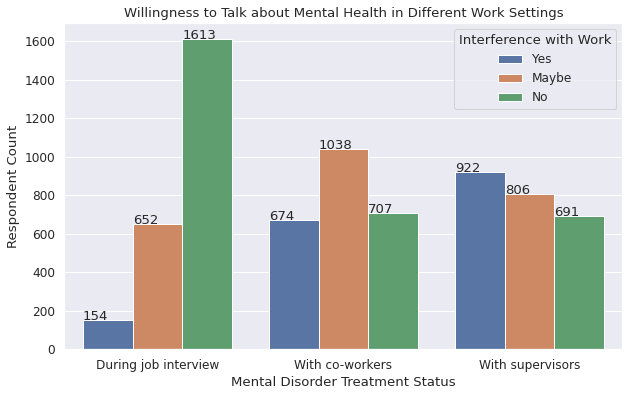

In [ ]:
query = """WITH Tech AS (SELECT DISTINCT UserID
                         FROM Answer
                         WHERE (SurveyID != 2014 
                         AND (QuestionID = 9 AND AnswerText = 1) 
                         OR (QuestionID = 13 AND AnswerText = 1))),
        
                SharingCircumstance AS (SELECT "During job interview" 
                                                AS SharingCircumstance, 
                                                Answertext AS Result, 
                                                COUNT(DISTINCT UserID) AS Cnt
                                        FROM Answer
                                        WHERE QuestionID = 12 and UserId in Tech
                                        GROUP BY Result
                                        UNION ALL
                                        SELECT "With co-workers" 
                                                AS SharingCircumstance, 
                                                Answertext AS Result, 
                                                COUNT(DISTINCT UserID) AS Cnt
                                        FROM Answer
                                        WHERE QuestionID = 18 and userId in Tech
                                        GROUP BY Result
                                        UNION ALL
                                        SELECT "With supervisors" 
                                                AS SharingCircumstance, 
                                                Answertext AS Result, 
                                                COUNT(DISTINCT UserID) AS Cnt
                                        FROM Answer
                                        WHERE QuestionID = 19 and userId in Tech
                                        GROUP BY Result)         
          SELECT SharingCircumstance,
                 MAX(CASE WHEN Result = "Yes" THEN Cnt END) AS Yes,
                 MAX(CASE WHEN Result = "Maybe" THEN Cnt END) AS Maybe,
                 MAX(CASE WHEN Result = "No" THEN Cnt END) AS No
          FROM SharingCircumstance
          GROUP BY SharingCircumstance
        """
answer_text = pd.read_sql(query, con)
hue_order=["Yes", "Maybe", "No"]
answer_text_melted = pd.melt(answer_text, 
                             id_vars=["SharingCircumstance"], 
                             value_vars=["Yes", "No", "Maybe"], 
                             var_name="SharingStatus", 
                             value_name="RespondentCount")


plt.figure(figsize=(10, 6))
ax = sns.barplot(data=answer_text_melted, 
            y="RespondentCount", 
            x="SharingCircumstance", 
            hue="SharingStatus", 
            hue_order=hue_order)
addbarlabel()
plt.title("Willingness to Talk about Mental Health in Different Work Settings")
plt.xlabel('Mental Disorder Treatment Status')
plt.ylabel('Respondent Count')
plt.legend(title="Interference with Work")
plt.show()

It is quite understandable that people tend to refrain from opening about a mental health issues during a job interview. Although, it is quite surprising that they are more likely to share their problems with their supervisors and not their co-workers. Altogether, willingness to share mental issues with supervisors seem to be relatively high. Yet, comparing to the aforementioned numbers of people who have ever experienced mental illness, it looks like the situation is still quite far from ideal since about 30% of employees with mental health disorders decide on hiding their illness from their supervisors.

### Openness about Mental Health and Demographic Factors

Have the willingness to discuss mental health with supervisors changed across the years 2017-2019?

In [ ]:
query = """WITH Tech AS (SELECT DISTINCT UserID
                         FROM Answer
                         WHERE (SurveyID != 2014 
                         AND (QuestionID = 9 AND AnswerText = 1) 
                         OR (QuestionID = 13 AND AnswerText = 1)))
           SELECT SurveyID AS Year, Answertext AS OpennessStatus
           FROM Answer
           WHERE QuestionID = 19 AND UserId IN Tech       
        """
openness_years = pd.read_sql(query, con)
openness_years_pivot = openness_years.groupby(
    "Year")["OpennessStatus"].value_counts()
openness_years_pivot = openness_years_pivot.rename(
    'RespondentCount').reset_index()
openness_years_pivot = pd.pivot(openness_years_pivot, columns="OpennessStatus", 
                                      index="Year", values="RespondentCount")
display(openness_years_pivot)

OpennessStatus,Maybe,No,Yes
Year,,,
2016,378,329,424
2017,220,162,254
2018,116,112,129
2019,92,88,115


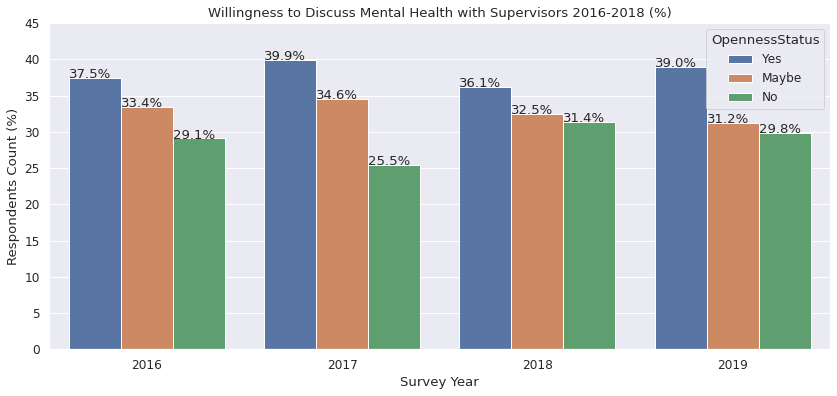

In [ ]:
openness_norm = openness_years.groupby("Year")["OpennessStatus"].value_counts(
    normalize=True)
openness_norm = openness_norm.mul(100).rename('Percent').reset_index()

plt.figure(figsize=(14, 6))
ax = sns.barplot(data=openness_norm, 
                 x="Year", 
                 y="Percent", 
                 hue="OpennessStatus")
addbarlabel("%")
ax.set_ylim(0, 45)
plt.title('Willingness to Discuss Mental Health with Supervisors \
2016-2018 (%)')
plt.xlabel('Survey Year')
plt.ylabel('Respondents Count (%)')
plt.show()

There seem to be no significant variation in respondent willingness to share mental heatlth problems with supervisors across different survey years.

In [ ]:
def techquery (questionID, columnName):

  '''Returns an SQLite query for the selection of Mental Health Survey answers 
     to question no. 19 together with answers with another prefered question
     provided by respondents who are working in tech industry.

     Parameters:
     questionID (int): An prefered QuestionID from Mental Health Survey table
     columnName (str): A name for the column with answers corresponding to 
                       the selected QuestionID from Mental Health Survey table

     Returns:
     str: SQLite query in a string format.
  '''
 
  query = """WITH Tech AS (SELECT DISTINCT UserID
                           FROM Answer
                           WHERE (SurveyID != 2014 
                           AND (QuestionID = 9 AND AnswerText = 1) 
                           OR (QuestionID = 13 AND AnswerText = 1)))
             SELECT a.AnswerText AS """ + str(columnName) + """,
                    b.AnswerText AS OpennessStatus
             FROM Answer a
             JOIN Answer b on b.UserID = a.UserID
             WHERE a.QuestionID = """ + str(questionID) + """
             AND b.QuestionID = 19 AND a.UserID IN Tech
           """
  return(query)

In which countries survey respondents worked in? How many different countries were mentioned in the survey?

In [ ]:
work_country = pd.read_sql(techquery(50, "Country"), con)
print(f'There are {work_country.Country.nunique()} \
different countries in the survey answers. \n\n')

There are 63 different countries in the survey answers. 




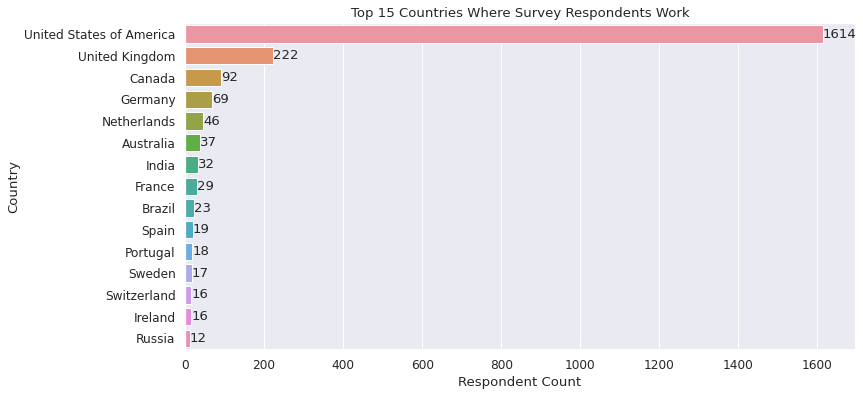

In [ ]:
order = work_country["Country"].value_counts()[:15].index

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=work_country, y="Country", order=order)
plt.title("Top 15 Countries Where Survey Respondents Work")
plt.xlabel('Respondent Count')
plt.ylabel('Country')
ax.bar_label(ax.containers[0])
plt.show()

The overwhelming majority of survey respondents work in the US. It is yet interesting to compare how willingness to discuss mental health varies in the US and other three countries from the top of the list.

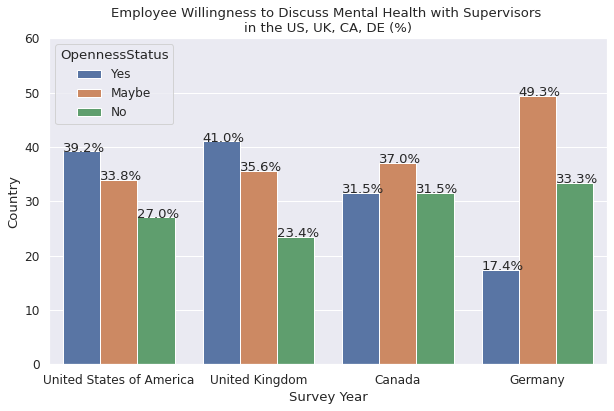

In [ ]:
work_country_norm = work_country.groupby(
    "Country")["OpennessStatus"].value_counts(normalize=True)
work_country_norm = work_country_norm.mul(100).rename('Percent').reset_index()
top_countries = work_country["Country"].value_counts()[:4].index

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=work_country_norm, 
                   x='Country',
                   y="Percent", 
                   hue="OpennessStatus", 
                   order=top_countries)
addbarlabel("%")
ax.set_ylim(0, 60)
plt.title('Employee Willingness to Discuss Mental Health with Supervisors \n\
in the US, UK, CA, DE (%)')
plt.xlabel('Survey Year')
plt.ylabel('Country')
plt.show()

Employee willingness to discuss mental problems with their supervisors looks to be much lower in Germany than it is in other 3 countries from the top list. But these differences should be taken with a grain of salt since there were significantly less survey respondents worrking in Germany than in the US or UK.

What is the relation of employee opennes about their mental health with their supervisors and employee age? How respondent age is distributed?

In [ ]:
age = pd.read_sql(techquery(1, "Age"), con)
age.head()
age["Age"] = age["Age"].astype("int64")
age.describe()

,Age
count,2419.000000
mean,34.207524
std,9.946171
min,0.000000
25%,28.000000
50%,33.000000
75%,39.000000
max,323.000000


The `age` column has some unusual values which need to be filtered out. Lower threshold of the filter will be set to 15 years, although legal working age slightly differs across the world. The higher threshold of the filter will be set to a dummy number of 90.

In [ ]:
age = age[(age["Age"] >= 15) & (age["Age"] <= 90)]
age.shape[0]

2415

Only three rows with odd data were dropped.

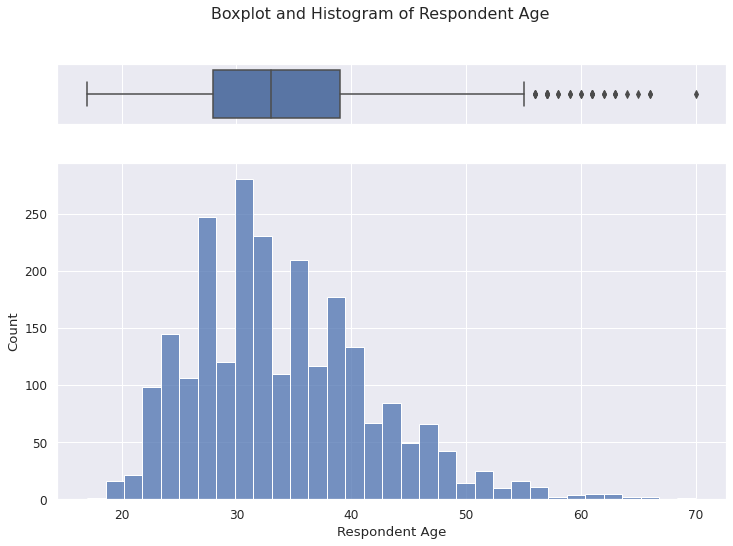

In [ ]:
f, ax = plt.subplots(2, 
                     figsize=(12, 8), 
                     gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=age.Age, ax=ax[0])
ax[0].set_xlabel(None)
ax[0].set_xticklabels([])
sns.histplot(x=age.Age, ax=ax[1])
ax[1].set_xlabel("Respondent Age")
plt.suptitle("Boxplot and Histogram of Respondent Age")
plt.show()

Survey respondents' age follows a normal distribution with few outliers on the right side of it. Most of the tech workers are people in the age of mid twenties to mid thirties. 

Does the age distribution look different when the factor of oppening about mental health to supervisors is taken in?

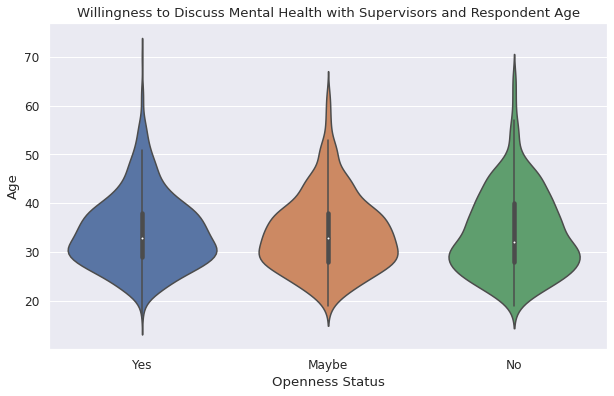

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=age, x="OpennessStatus", y="Age")
plt.title('Willingness to Discuss Mental Health with Supervisors and Respondent\
 Age')
plt.xlabel('Openness Status')
plt.ylabel('Age')
plt.show()

There are no big differences in age distributions among people who are more willing to share their mental health issues and with those who are not. Although, the distribution of those who are reluctant of sharing their problems seem to be slightly more uniform meaning there is a greater variety of people of different age in this group.

How does employee willingnes to open up about mental health to supervisors differes among genders?

In [ ]:
gender = pd.read_sql(techquery(2, "Gender"), con)
gender["Gender"].unique()

array(['Male', 'Female', 'Bigender', 'non-binary',
       'Female assigned at birth', 'fm', 'Transitioned, M2F',
       'Genderfluid (born female)', 'Other/Transfeminine',
       'Female or Multi-Gender Femme', 'Androgynous',
       'male 9:1 female, roughly', '-1', 'Other', 'nb masculine',
       'none of your business', 'genderqueer', 'Human', 'Genderfluid',
       'Enby', 'genderqueer woman', 'Queer', 'Agender',
       'Male/genderqueer', 'Nonbinary', 'Male (trans, FtM)',
       'Genderqueer', 'Genderflux demi-girl',
       'female-bodied; no feelings about gender', 'Transgender woman',
       'male', 'female', 'uhhhhhhhhh fem genderqueer?',
       'God King of the Valajar', 'Non-binary', 'Agender/genderfluid',
       'Male-ish', 'sometimes', 'Contextual', 'Non binary',
       'Genderqueer demigirl', 'Genderqueer/non-binary', 'nonbinary',
       '\\-', 'Transfeminine', 'None', 'Ostensibly Male', 'Trans man',
       'transgender', 'non binary', 'Female/gender non-binary.',
       'Tr

As there seem to be quite a big variety of gender interpretations among survey respondents, to ease the analysis, their answers will be categorized into three groups: male, female and other.

In [ ]:
query = """WITH Tech AS (SELECT DISTINCT UserID
                         FROM Answer
                         WHERE (SurveyID != 2014 
                         AND (QuestionID = 9 AND AnswerText = 1) 
                         OR (QuestionID = 13 AND AnswerText = 1)))
           SELECT (CASE
                    WHEN UPPER(a.AnswerText) LIKE "%FEM%" THEN "Female"
                    WHEN UPPER(a.AnswerText) LIKE "%WOMAN%" THEN "Female"
                    WHEN UPPER(a.AnswerText) LIKE "%MALE%" THEN "Male"
                    WHEN UPPER(a.AnswerText) LIKE "%MASCUL%" THEN "Male"
                    ELSE "Other"
                    END) AS Gender,
                    B.AnswerText AS OpennessStatus
           FROM Answer a
           JOIN Answer b ON b.UserID = a.UserID
           WHERE a.QuestionID = 2 AND b.QuestionID = 19 AND a.UserID in Tech
           """
gender = pd.read_sql(query, con)
display(gender["Gender"].value_counts().to_frame(name="RespondentCount"))

,RespondentCount
Male,1685
Female,656
Other,78


The results show that the tech industry workers are predominantly male. 

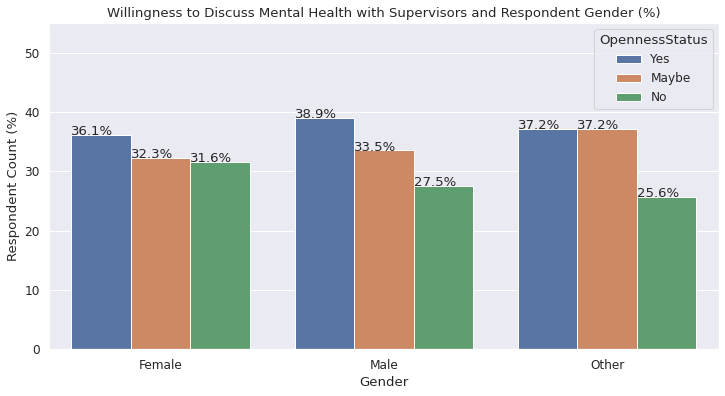

In [ ]:
gender_norm = gender.groupby(
    "Gender")["OpennessStatus"].value_counts(normalize=True)
gender_norm = gender_norm.mul(100).rename('Percent').reset_index()
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=gender_norm,
                 x="Gender", 
                 y="Percent", 
                 hue="OpennessStatus")
addbarlabel("%")
ax.set_ylim(0, 55)
plt.title('Willingness to Discuss Mental Health with Supervisors and \
Respondent Gender (%)')
plt.xlabel('Gender')
plt.ylabel('Respondent Count (%)')
plt.show()

After normalizing the respondent count for every gender group, it became clear that male respondents tend to be more vocal about their mental health to their supervisors then respondents of other genders. Yet, the differences are not too drastic.

### Openness about Mental Health and Company Environment

In this part, several factors from the overall company environment will be looked at in relation with respondent willingness to discuss their mental health with their supervisors. These factors include company size, supply of mental health benefits, supply of resources about mental health, formal discussion about mental health, anonimity protection, and difficulty of taking a medical leave for mental health treatment.

What are the sizes of the companies that tech respondents work in? Does the company size have an impact on oppeness about mental health?

In [ ]:
company_size = pd.read_sql(techquery(8, "EmployeeCount"), con)
df = company_size["EmployeeCount"].value_counts().to_frame(
    name="RespondentCount")
display(df)

,RespondentCount
More than 1000,614
100-500,606
26-100,531
6-25,394
500-1000,184
1-5,90


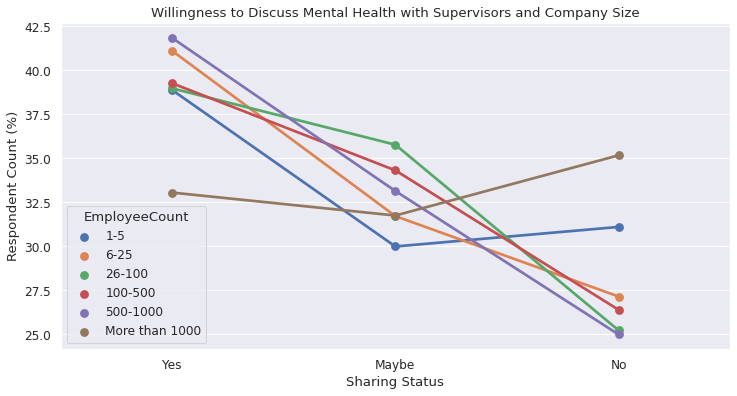

In [ ]:
company_size_norm = company_size.groupby(
    "EmployeeCount")["OpennessStatus"].value_counts(normalize=True)
company_size_norm = company_size_norm.mul(100).rename('Percent').reset_index()

order=["Yes", "Maybe", "No"]
hue_order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]

plt.figure(figsize=(12, 6))
sns.pointplot(data=company_size_norm, 
              x="OpennessStatus",
              y="Percent", 
              hue="EmployeeCount", 
              hue_order=hue_order, 
              order=order)
plt.title('Willingness to Discuss Mental Health with Supervisors and \
Company Size')
plt.xlabel('Sharing Status')
plt.ylabel('Respondent Count (%)')
plt.show()

We can clearly see that only workers of the largest companies that have employee count above 1000 are more unwilling than willing to discuss their mental health with supervisors. This fact is worthy to take into consideration since about a third of respondents revealed that they work for companies of the largest size.

Do respondents' employers provide of mental health benefits as part of healthcare coverage? How does ir relate to employee openness about mental health?

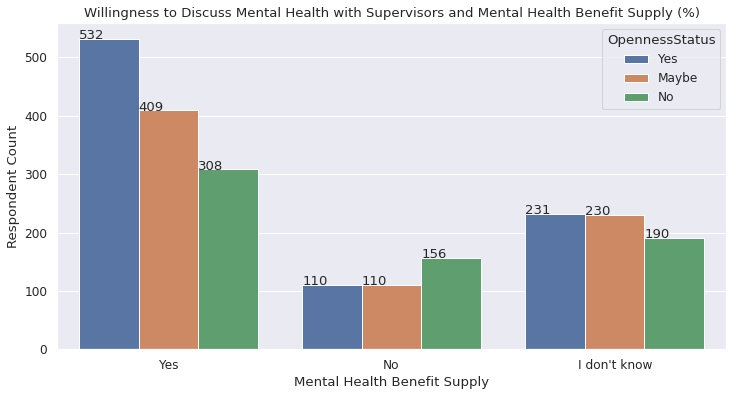

In [ ]:
benefit_supply = pd.read_sql(techquery(10, "BenefitStatus"), con)
benefit_supply = \
benefit_supply[benefit_supply["BenefitStatus"] \
               != "Not eligible for coverage / NA"]
order=["Yes", "No", "I don't know"]
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=benefit_supply, 
                   x="BenefitStatus", 
                   hue="OpennessStatus",
                   order=order)
addbarlabel()
plt.title('Willingness to Discuss Mental Health with Supervisors and \
Mental Health Benefit Supply (%)')
plt.xlabel('Mental Health Benefit Supply')
plt.ylabel('Respondent Count')
plt.show()

It seems that majority of the employers provide mental health benefits as part of healthcare coverage and it has a positive impact on employee willingness to talk about their mental health.

Do respondents know the particular options for mental health care available under your employer-provided health coverage? How does it relate to their willingness to open up?

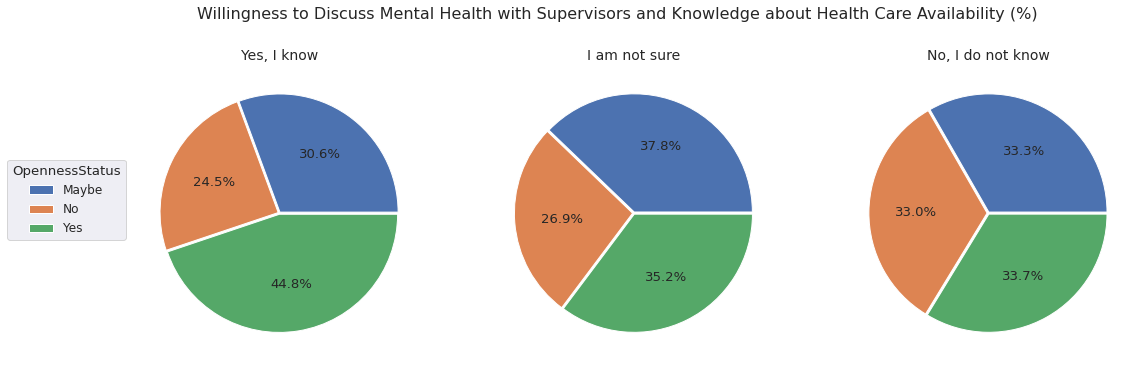

In [ ]:
coverage_knowledge = pd.read_sql(techquery(14, "KnowledgeOfCoverage"), con)
coverage_knowledge = \
coverage_knowledge[coverage_knowledge["KnowledgeOfCoverage"] != "-1"]

ax0 = coverage_knowledge[coverage_knowledge["KnowledgeOfCoverage"] == "Yes"]
ax0 = ax0.groupby("OpennessStatus").count()
ax1 = \
coverage_knowledge[coverage_knowledge["KnowledgeOfCoverage"] == "I am not sure"]
ax1 = ax1.groupby("OpennessStatus").count()
ax2 = coverage_knowledge[coverage_knowledge["KnowledgeOfCoverage"] == "No"]
ax2 = ax2.groupby("OpennessStatus").count()

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Willingness to Discuss Mental Health with Supervisors and \
Knowledge about Health Care Availability (%)", fontsize=16)
ax[0].pie(ax0.values.flatten(), labels = None, autopct='%1.1f%%',
            explode=[0.01] * 3)
ax[0].set_title("Yes, I know", fontsize=14)
ax[1].pie(ax1.values.flatten(), labels = None, autopct='%1.1f%%',
            explode=[0.01] * 3)
ax[1].set_title("I am not sure", fontsize=14)
ax[2].pie(ax2.values.flatten(), labels = None, autopct='%1.1f%%',
            explode=[0.01] * 3)
ax[2].set_title("No, I do not know", fontsize=14)

ax[0].legend(bbox_to_anchor=(0, 0.7), title="OpennessStatus", labels=ax1.index)
plt.show()

There is a tendency that those who do know all the options available for mental health care available tend to be more willing to discuss their mental health with supervisors. Thus, employers need to be more vocal to their employess about all choices if they provide health coverage.

Do respondents' employers offer resources to learn more about mental health disorders and options for seeking help? How does this help them open up about their mental health?

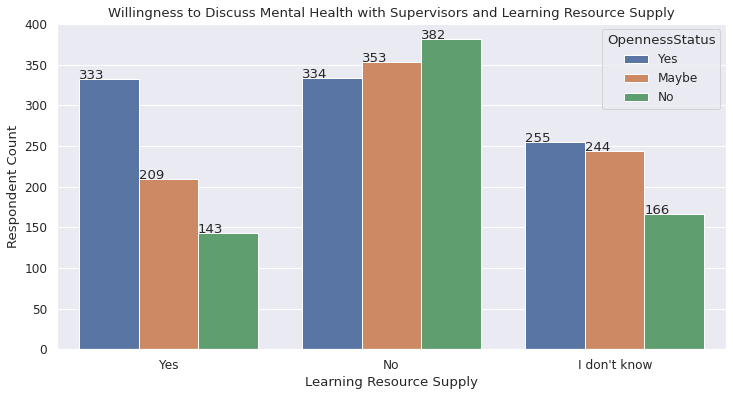

In [ ]:
learning_resources = pd.read_sql(techquery(16, "LearningResources"), con)
plt.figure(figsize=(12, 6))

order=["Yes", "No", "I don't know"]
ax = sns.countplot(data=learning_resources, 
                   x="LearningResources",
                   hue="OpennessStatus",
                   order=order)
addbarlabel()
plt.title('Willingness to Discuss Mental Health with Supervisors and \
Learning Resource Supply')
plt.xlabel('Learning Resource Supply')
plt.ylabel('Respondent Count')
plt.show()

According to survey respondents, almost half of the employers do not provide any resources about mental health disorders and their treatment options. It is truly a place to improve since there is a quite obvious relation with learning resource availability and tendency to speak up about mental health issues.

Do employers of tech industry ever formally discussed mental health (as part of a wellness campaign or other official communication) with their employess. How does it impact employee willingness to reveal their mental health situation?

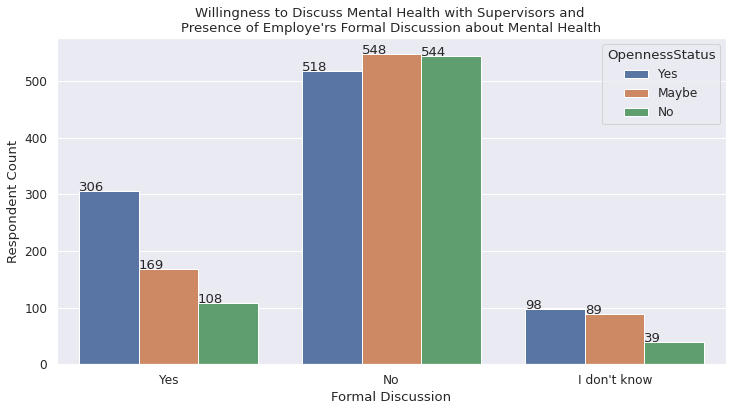

In [ ]:
formal_discussion = pd.read_sql(techquery(15, "FormalDiscussion"), con)
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=formal_discussion, 
                   x="FormalDiscussion", 
                   hue="OpennessStatus",
                   order=order)
addbarlabel()
plt.title("Willingness to Discuss Mental Health with Supervisors and \n\
Presence of Employe'rs Formal Discussion about Mental Health")
plt.xlabel('Formal Discussion')
plt.ylabel('Respondent Count')
plt.show()

The majority of tech industry workers did not have a formal discussion about mental health with their employers although it looks like it has a positive impact on employee willingness to reveal their mental health problems to their supervisors.

Is tech employee anonymity protected if they choose to take advantage of mental health or substance abuse treatment resources provided by their employer? How does it influence their openness about mental health?

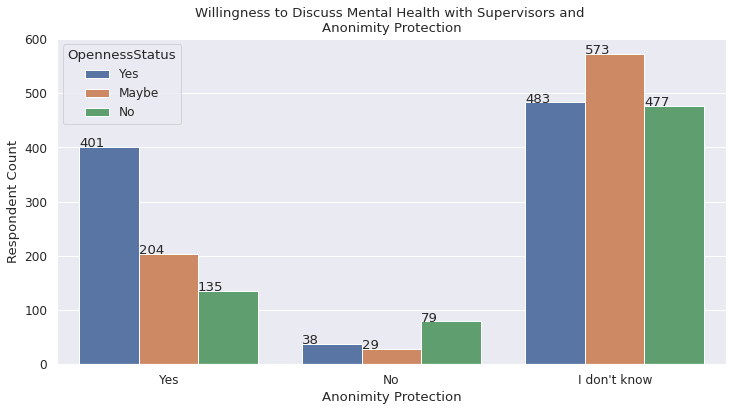

In [ ]:
anonimity_promotion = pd.read_sql(techquery(11, "AnonimityProtection"), con)
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=anonimity_promotion,
                   x="AnonimityProtection",
                   hue="OpennessStatus",
                   order=order)
addbarlabel()
plt.title("Willingness to Discuss Mental Health with Supervisors and \n\
Anonimity Protection")
plt.xlabel('Anonimity Protection')
plt.ylabel('Respondent Count')
plt.show()

Most of the respondents admitted that they do not know if their anonimity about mental health is protected and this seems to boost their unwillingness to discuss their problems with their supervisors.

If a mental health issue prompted to request a medical leave from work, how easy or difficult for the tech workers would it be to ask for that leave? How does it relate to their willingness to discuss mental health problems?

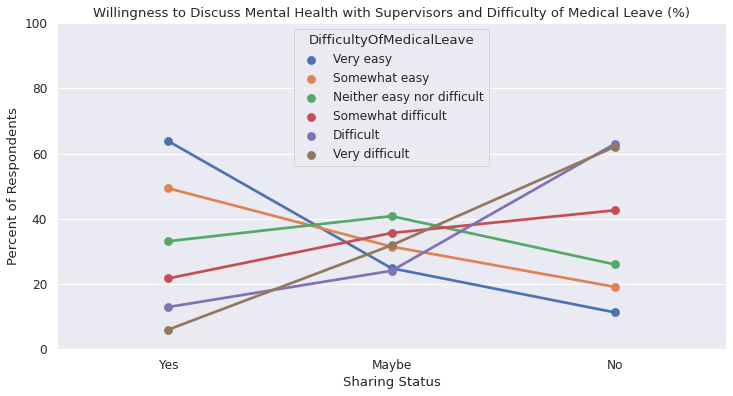

In [ ]:
leave_difficulty = pd.read_sql(techquery(17, "DifficultyOfMedicalLeave"), con)
leave_difficulty_norm = leave_difficulty.groupby(
    "DifficultyOfMedicalLeave")["OpennessStatus"].value_counts(normalize=True)
leave_difficulty_norm = leave_difficulty_norm.mul(100).rename(
    'Percent').reset_index()

order=["Yes", "Maybe", "No"]
hue_order = ["Very easy", 
             "Somewhat easy", 
             "Neither easy nor difficult", 
             "Somewhat difficult", 
             "Difficult", 
             "Very difficult"]

plt.figure(figsize=(12, 6))
sns.pointplot(data=leave_difficulty_norm, 
              x="OpennessStatus",
              y="Percent", 
              hue="DifficultyOfMedicalLeave",
              order=order,
              hue_order=hue_order)
plt.title('Willingness to Discuss Mental Health with Supervisors and Difficulty\
 of Medical Leave (%)')
plt.xlabel('Sharing Status')
plt.ylabel('Percent of Respondents')
plt.ylim(0, 100)
plt.show()

It looks like there is a quite obvious positive correlation with easiness of taking a mental health leave and employee willingness to reveal their mental health problems to their supervisors.

## Conclusions and Suggestions on Improving Mental Health Situation in the Tech Industry

Conclusions:
*   Mental health disorders are a pressing issue in the tech industry as more than half of the respondents revealed they were affected by them at some point in their life.
*   Openness about mental health problems within the working sphere of tech industries is still an issue which requires to be acted on since about a third of their employees refrain from discussing mental illness with their supervisors. 
*   Willingness to discuss mental health issues with supervisors has a more obvious relation with company environment than with demographic factors. Therefore, teoretically it is possible for the employers to introduce a change to their employee well-being.



Suggestions:


*   **More resources needed**: provide mental health benefits as part of company healthcare coverage; make medical leave for mental health problems easier.
*   **Less resources needed**: make sure that learning material about mental health prevention and treatment is available within working space; organize an official discussion about mental health (eg., a workshop or a wellness campaign); bring additional means to monitor worker well-being if the company has a large number of employees.
*   **No resources needed**: if the company already provides mental health benefits, learning resources, and garuantees anonimity when employees chose to take treatment for mental disorders, be sure to accentuate all available options and emphasize full disclosure. A big part of the problem of employees hiding their mental health struggles is the fact that they do not know of all of the readily available resources and support.





## Thoughts on How to Improve this EDA:



*   Try Principal Component and/or Factor analysis
*   Try to look at the survey questions that are designed to provide qualitative information (from the surveys of 2017-2019). Maybe make some word clouds of respondent answers.

